## Data preprocessing
in this file we gonna prepare, visualize and initialaze the label of each images and save that into a file

### Import data
get data from kaggle

In [1]:
# !mkdir '/root/.kaggle'
# !echo <your username and key of kaggle account> > '/root/.kaggle/kaggle.json'
# !kaggle datasets download -d andrewmvd/face-mask-detection

In [2]:
# !unzip '/content/face-mask-detection.zip'
# !rm -rf '/content/face-mask-detection.zip'

### Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle as pkl
import requests
import cv2
import os
import warnings

from plotly import graph_objects as go
from plotly import express as px
from xml.etree import ElementTree as et
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from collections import Counter
from google.colab.patches import cv2_imshow
from keras.models import Sequential
from keras.layers.experimental import preprocessing as ps
from keras.layers.experimental import preprocessing as ps
from keras.utils import to_categorical
from io import BytesIO
from PIL import Image as pil

### preprocess data

In [4]:
# create an empty list
data = []
label2category = {'with_mask': 0, 'without_mask': 1, 'mask_weared_incorrect': 2}
category2label = {0: 'with_mask', 1: 'without_mask', 2: 'mask_weared_incorrect'}
category2color = {0: (0,255,0), 1: (0,0,255), 2: (0,165,255)}

In [5]:
for dir, _, files in os.walk('/content/annotations'):
  for file_ in files:
    dict_ = dict(img_path=None, objs=[])

    path = os.path.join(dir, file_)
    tree = et.parse(path)
    dict_['img_path'] = os.path.join('/content/images', tree.find('filename').text)
    for obj in tree.findall('object'):
      label = obj.find('name').text

      xmin = int(obj.find('bndbox/xmin').text)
      ymin = int(obj.find('bndbox/ymin').text)
      xmax = int(obj.find('bndbox/xmax').text)
      ymax = int(obj.find('bndbox/ymax').text)

      dict_['objs'].append([xmin, ymin, xmax, ymax, label2category[label]])
    data.append(dict_)

### Visualize images

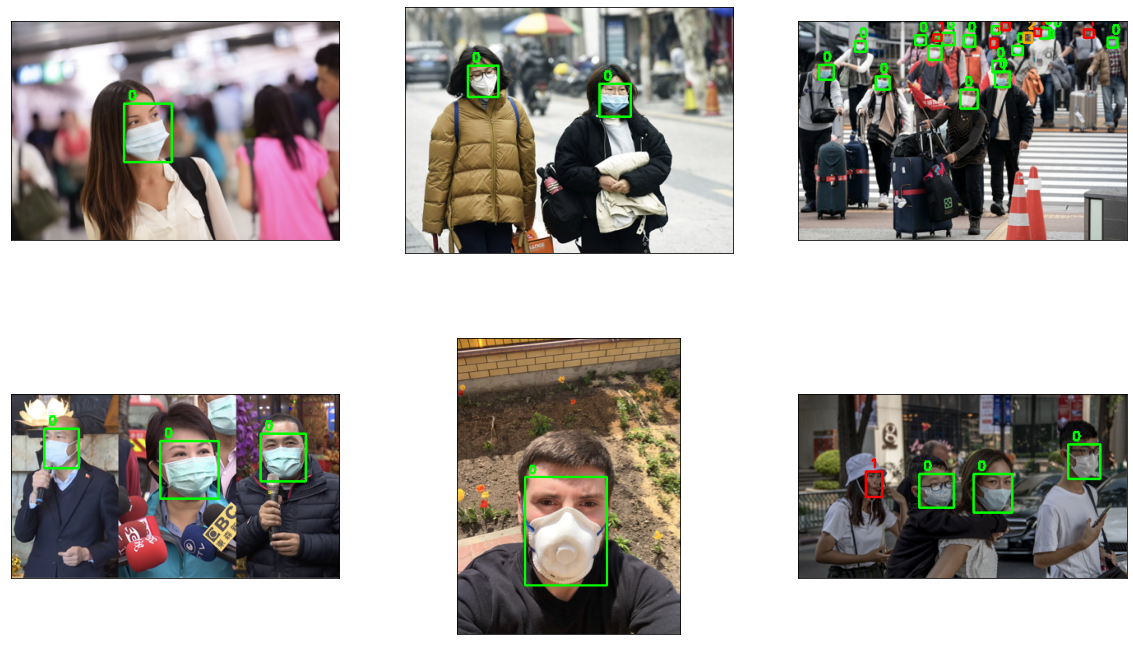

CPU times: user 852 ms, sys: 14.1 ms, total: 866 ms
Wall time: 918 ms


In [6]:
# visualize images
%%time

plt.figure(figsize=(20,12))

for i, _data in enumerate(data[22:28]):
  img = cv2.imread(_data['img_path'])
  for (xmin, ymin, xmax, ymax, label) in _data['objs']:
    cv2.rectangle(img , (xmin, ymin), (xmax, ymax), category2color[label], 2)
    cv2.putText(img, str(label), (xmin+5, ymin-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, category2color[label], 2)
  plt.subplot(2,3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()

In [7]:
labels = []
for _data in data:
  for (xmin, ymin, xmax, ymax, label) in _data['objs']:
    label = category2label[label]
    labels.append(label)

labels = np.array(labels)
labels_count = Counter(labels)

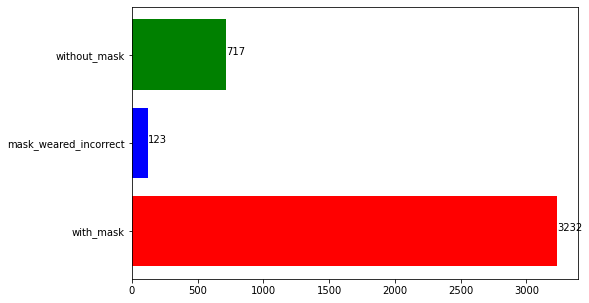

In [8]:
plt.figure(figsize=(8,5))

plt.barh(list(labels_count.keys()), list(labels_count.values()), color=['r', 'b', 'g'])
for i,v in enumerate(labels_count.values()):
  plt.text(v, i, str(v))
plt.show()

### Images augmentation

In [9]:
wom_image = pkl.load(open('/content/drive/My Drive/Data Science/Project/Mask detection/dumps/without_mask.array', 'rb'))

In [10]:
def augment_data(input_img, aument_model, input_label=None, list_input=True, iterate=3):
  img_list = []
  label = []

  if not list_input:
    target = to_categorical(input_label, num_classes=3)
    for i, img in enumerate(input_img):
      for _ in range(iterate):
        batch = tf.expand_dims(img, 0)
        aug = aug_model(batch)
        img_list.append(np.array(aug[0]))
        label.append(target)
    return img_list, label

  else:
    label = None
    for _ in range(iterate):
      batch = tf.expand_dims(input_img, 0)
      aug = aug_model(batch)
      img_list.append(np.array(aug[0]))
    return img_list

In [11]:
aug_model = Sequential()
aug_model.add(ps.RandomFlip())
aug_model.add(ps.RandomRotation(0.4))

In [12]:
images, im_targets = augment_data(wom_image, aug_model, 1, list_input=False)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [13]:
len(images) == len(im_targets)

True

In [14]:
images_array = np.array(images)
target_array =  np.array(im_targets)

### Split data

In [15]:
# cut only faces at the picture
%%time

x = []
y = []
IMG_SIZE = (64,64)

for _data in data:

  img_path = _data['img_path']
  for (xmin, ymin, xmax, ymax, label) in _data['objs']:
    img = cv2.imread(img_path)
    crop_img = img[ymin : ymax, xmin : xmax]
    re_img = cv2.resize(crop_img, IMG_SIZE)
    re_img = re_img/255
    target = to_categorical(label, num_classes=3)

    if label == 2:
      aug_img = augment_data(re_img, aug_model, iterate=10)
      for aug in aug_img:
        x.append(np.array(aug)); y.append(target)
    else:
      x.append(re_img); y.append(target)

CPU times: user 57.3 s, sys: 1.58 s, total: 58.9 s
Wall time: 59 s


In [16]:
x = np.array(x)
y = np.array(y)

In [17]:
print('inputs data shape: {}'.format(x.shape))
print('outputs data shape: {}'.format(y.shape))

inputs data shape: (5179, 64, 64, 3)
outputs data shape: (5179, 3)


### merge the two array

In [18]:
X = np.vstack((x, images_array))
Y = np.vstack((y, target_array))

print(X.shape)
print(Y.shape)

(7330, 64, 64, 3)
(7330, 3)


In [19]:
def category_convert(data):
  num = []
  for i in range(len(data)):
    num.append(category2label[data[i].argmax()])
  counter = Counter(num)

  return counter

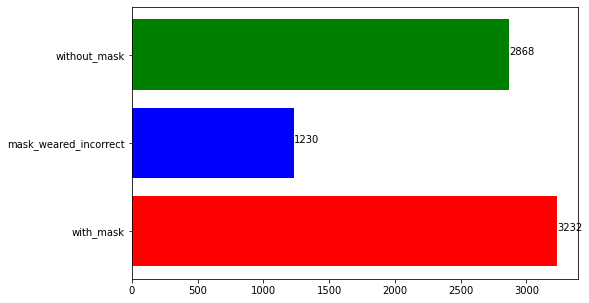

In [20]:
merge_label = category_convert(Y)

plt.figure(figsize=(8,5))

plt.barh(list(merge_label.keys()), list(merge_label.values()), color=['r', 'b', 'g'])
for i,v in enumerate(merge_label.values()):
  plt.text(v, i, str(v))
plt.show()

### split data into train and test

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

In [22]:
print('x_train shape: {}'.format(x_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

x_train shape: (5864, 64, 64, 3)
x_test shape: (1466, 64, 64, 3)
y_train shape: (5864, 3)
y_test shape: (1466, 3)


In [23]:
def percent(df):
  _sum = df.sum()
  per = (df/_sum) * 100
  return per

def df_counter(train_counter, test_counter):
  df = pd.DataFrame(columns=['train', 'test'])
  for x in list(train_counter.keys()):
    df.loc[x] = [train_counter[x], test_counter[x]]
  return df

In [24]:
num_train = category_convert(y_train)
num_test = category_convert(y_test)

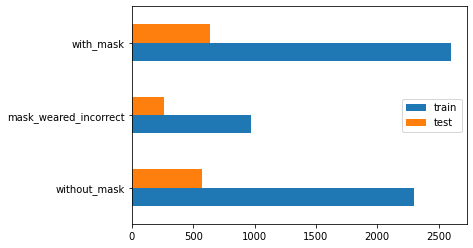

In [25]:
df = df_counter(num_train, num_test)
df.plot(kind='barh')

In [26]:
p_train = percent(df['train'])
p_test = percent(df['test'])

print('in train data:\n with mask: {:.2f} %, without mask: {:.2f} %, mask weared incorrect: {:.2f} %'\
      .format(p_train['with_mask'], p_train['without_mask'], p_train['mask_weared_incorrect']))
print('in test data:\n with mask: {:.2f} %, without mask: {:.2f} %, mask weared incorrect: {:.2f} %'\
      .format(p_test['with_mask'], p_test['without_mask'], p_test['mask_weared_incorrect']))

in train data:
 with mask: 44.30 %, without mask: 39.19 %, mask weared incorrect: 16.51 %
in test data:
 with mask: 43.25 %, without mask: 38.88 %, mask weared incorrect: 17.87 %


### save data into npz file

In [28]:
np.savez('/content/drive/My Drive/Data Science/DataSet/NPZ/masks_data', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)